In [1]:
#finds all pathnames matching a pattern, like regex
import glob
#log events for libraries
import logging
#concurrency
import multiprocessing
#dealing with operating system , like reading file
import os
#pretty print, human readable
import pprint
#regular expressions
import re
import io
import time

In [2]:
#natural language toolkit
import nltk
from nltk import word_tokenize
#word 2 vec
import gensim.models.word2vec as w2v
import gensim.models.keyedvectors as kv
#dimensionality reduction
import sklearn.manifold
#math
import numpy as np
#plotting
import matplotlib.pyplot as plt
#parse dataset
import pandas as pd
#visualization
import seaborn as sns

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
DATA_PATH = '/kaggle/dev/ashish/word_vectors_harry_potter/data/'
files = glob.glob(DATA_PATH + "*.txt")

for file in files:
    print(os.path.basename(file))

hp3.txt
hp1.txt
hp5.txt
hp6.txt
hp7.txt
hp4.txt
hp2.txt


In [5]:
text_raw = u""
for file in files:
    with io.open(file,'r',encoding='utf8') as f:
        text_raw += f.read()
print('Books contain {} characters'.format(len(text_raw)))

Books contain 6286105 characters


In [6]:
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
sentences_raw = sent_detector.tokenize(text_raw.strip())
print('Books contain {} sentences'.format(len(sentences_raw)))
print(sentences_raw[1000:1010])

Books contain 61595 sentences
['We had to ask him if he minds the Azkaban guards stationing themselves around the entrances to the school grounds.', 'He wasn’t happy about it, but he agreed.”\n\n“Not happy?', 'Why shouldn’t he be happy, if they’re there to catch Black?”\n\n“Dumbledore isn’t fond of the Azkaban guards,” said Mr. Weasley heavily.', '“Nor am I, if it comes to that … but when you’re dealing with a wizard like Black, you sometimes have to join forces with those you’d rather avoid.”\n\n“If they save Harry —”\n\n“— then I will never say another word against them,” said Mr. Weasley wearily.', '“It’s late, Molly, we’d better go up.', '…”\n\nHarry heard chairs move.', 'As quietly as he could, he hurried down the passage to the bar and out of sight.', 'The parlor door opened, and a few seconds later footsteps told him that Mr. and Mrs. Weasley were climbing the stairs.', 'The bottle of rat tonic was lying under the table they had sat at earlier.', 'Harry waited until he heard Mr.

In [7]:
sentences_words = []
def clean_sentences(sentence):
    s = re.sub(r'[^a-zA-Z]', " ", sentence)
    s = s.split()
    return s

for sentence in sentences_raw:
    sentences_words.append(clean_sentences(sentence))
    
print(sentences_words[1000:1010])

[['We', 'had', 'to', 'ask', 'him', 'if', 'he', 'minds', 'the', 'Azkaban', 'guards', 'stationing', 'themselves', 'around', 'the', 'entrances', 'to', 'the', 'school', 'grounds'], ['He', 'wasn', 't', 'happy', 'about', 'it', 'but', 'he', 'agreed', 'Not', 'happy'], ['Why', 'shouldn', 't', 'he', 'be', 'happy', 'if', 'they', 're', 'there', 'to', 'catch', 'Black', 'Dumbledore', 'isn', 't', 'fond', 'of', 'the', 'Azkaban', 'guards', 'said', 'Mr', 'Weasley', 'heavily'], ['Nor', 'am', 'I', 'if', 'it', 'comes', 'to', 'that', 'but', 'when', 'you', 're', 'dealing', 'with', 'a', 'wizard', 'like', 'Black', 'you', 'sometimes', 'have', 'to', 'join', 'forces', 'with', 'those', 'you', 'd', 'rather', 'avoid', 'If', 'they', 'save', 'Harry', 'then', 'I', 'will', 'never', 'say', 'another', 'word', 'against', 'them', 'said', 'Mr', 'Weasley', 'wearily'], ['It', 's', 'late', 'Molly', 'we', 'd', 'better', 'go', 'up'], ['Harry', 'heard', 'chairs', 'move'], ['As', 'quietly', 'as', 'he', 'could', 'he', 'hurried', 'do

In [8]:
token_count = 0
for sentence in sentences_words:
    token_count += len(sentence)
print('Books contain {} tokens'.format(token_count))

Books contain 1124921 tokens


In [83]:
seed = 42
num_workers = multiprocessing.cpu_count()
num_features = 300
min_word_count = 3
context_size = 7
downsampling = 1e-3

In [84]:
hpvec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

hpvec.build_vocab(sentences_words)

print("hpvec vocabulary length:", len(hpvec.wv.vocab))

hpvec vocabulary length: 13129


In [85]:
hpvec.train(sentences_words, total_examples=hpvec.corpus_count, epochs=hpvec.iter)

4266785

In [86]:
# Save model
if not os.path.exists("trained_model"):
    os.makedirs("trained_model")
hpvec.save(os.path.join("trained_model", "hpvec-3.w2v"))

In [87]:
# Load model
hpvec = w2v.Word2Vec.load(os.path.join("trained_model", "hpvec-3.w2v"))

In [88]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [89]:
all_word_vectors_matrix = hpvec.wv.syn0
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [90]:
#plot point in 2d space
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[hpvec.wv.vocab[word].index])
            for word in hpvec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

points.head(10)

,word,x,y
0,tall,1.376999,2.507250
1,intends,-4.777223,-5.724960
2,Draught,-6.029623,-2.577950
3,weakened,-4.659810,-3.915131
4,blot,2.072735,-0.789258
5,MY,-2.162139,5.642520
6,sight,-2.238152,3.051777
7,President,-0.902448,-5.723118
8,Potter,2.430111,-0.281753
9,performed,-5.203716,-1.621913


In [91]:
sns.set_context("poster")

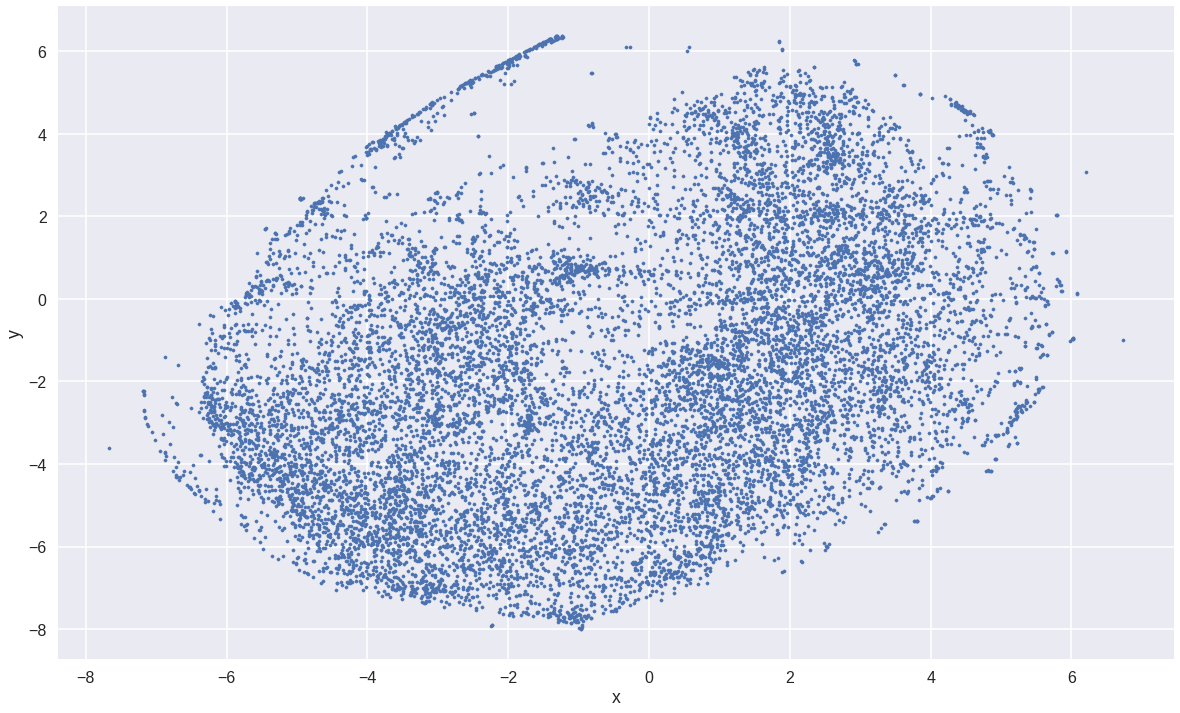

In [92]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [93]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(20, 16))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word.lower(), fontsize=11)
        
def plot_around(word, bounds):
    coord_x = points[points.word == word].iloc[0,1]
    coord_y = points[points.word == word].iloc[0,2]
    slice = points[
        (coord_x - bounds <= points.x) &
        (points.x <= coord_x + bounds) & 
        (coord_y - bounds <= points.y) &
        (points.y <= coord_y + bounds)
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(20, 16))
    for i, point in slice.iterrows():
        if point.word == word:
            ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11, color='red')
        else:
            ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

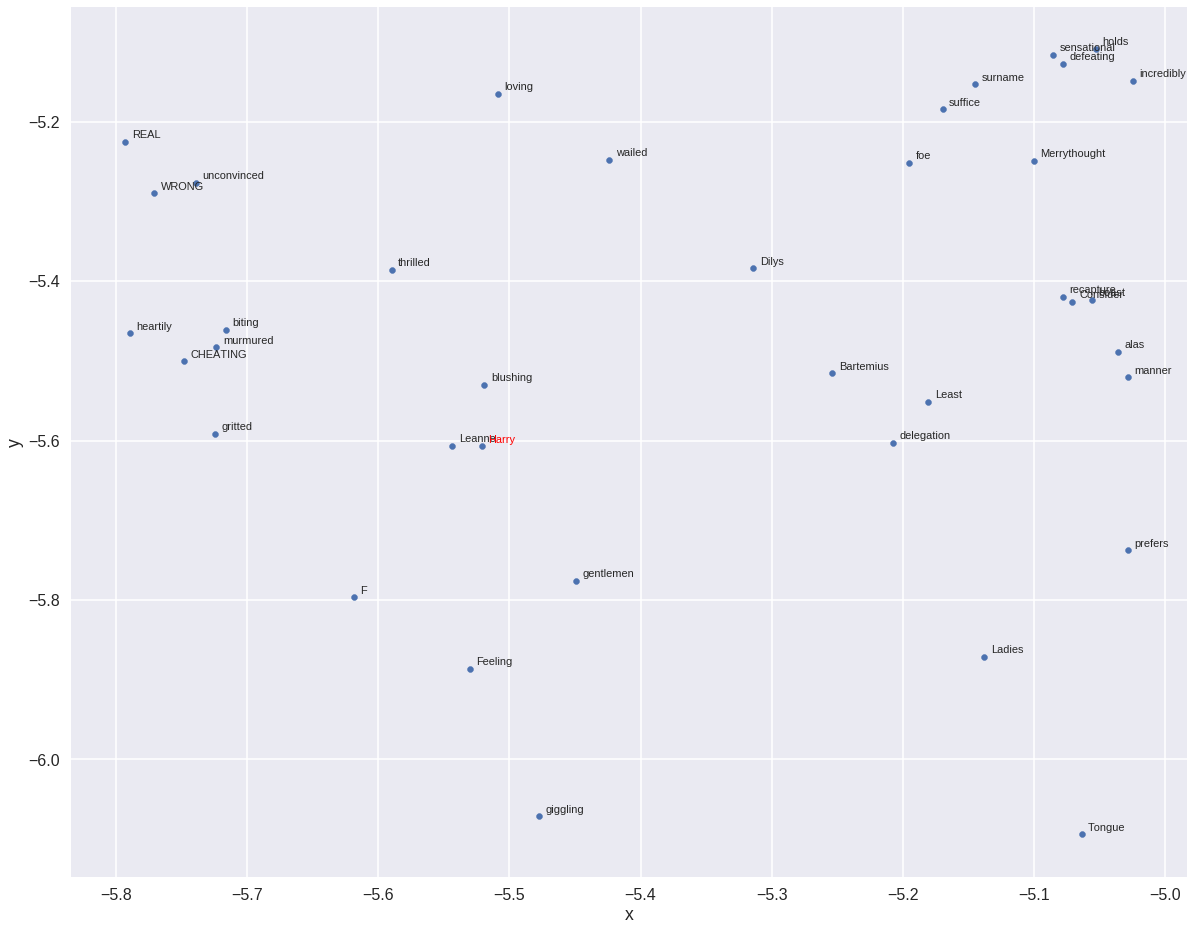

In [94]:
plot_around("Harry", 0.5)

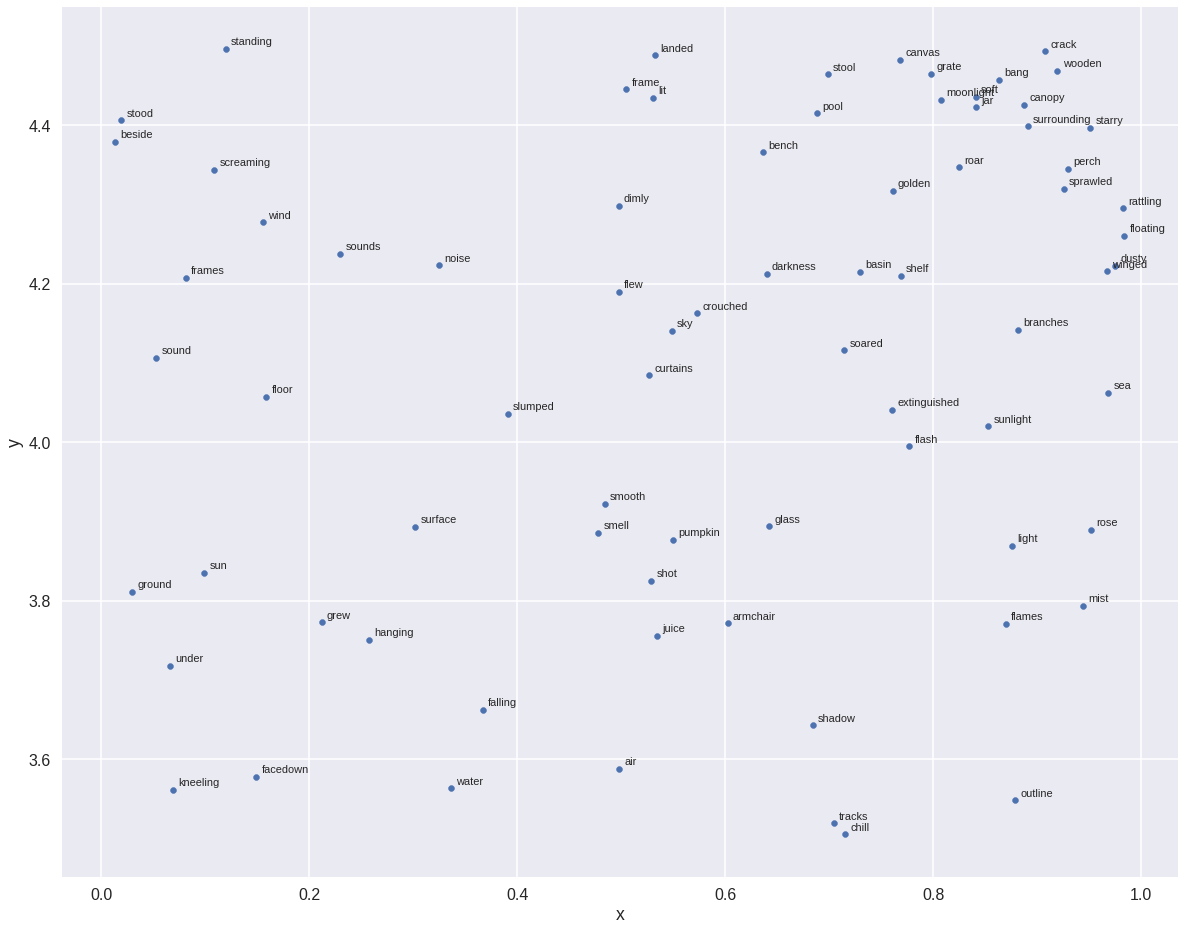

In [95]:
plot_region(x_bounds=(0, 1), y_bounds=(3.5, 4.5))

In [96]:
hpvec.most_similar("Dobby")

[('Kreacher', 0.7686378955841064),
 ('elf', 0.7494997978210449),
 ('sir', 0.7334563136100769),
 ('Winky', 0.6838953495025635),
 ('squeaked', 0.6667753458023071),
 ('Master', 0.6616872549057007),
 ('freed', 0.6184630393981934),
 ('Firenze', 0.6162880659103394),
 ('obey', 0.5862468481063843),
 ('gillyweed', 0.5828290581703186)]

In [97]:
hpvec.most_similar("Ron")

[('Ginny', 0.6654828786849976),
 ('Colin', 0.6411886811256409),
 ('shrugged', 0.6340556144714355),
 ('bewildered', 0.6266912221908569),
 ('blushing', 0.6266181468963623),
 ('Ears', 0.6259548664093018),
 ('miserably', 0.623539388179779),
 ('McLaggen', 0.6230485439300537),
 ('anxiously', 0.6226203441619873),
 ('tentatively', 0.6215314269065857)]

In [98]:
hpvec.most_similar("Voldemort")

[('Wormtail', 0.7420217990875244),
 ('Lord', 0.7224560976028442),
 ('Elder', 0.6999149322509766),
 ('Wand', 0.676884651184082),
 ('Bellatrix', 0.6688957214355469),
 ('Stone', 0.6642591953277588),
 ('Quirrell', 0.6613593101501465),
 ('thoughts', 0.6504322290420532),
 ('Ariana', 0.648639976978302),
 ('prophecy', 0.6472694873809814)]

In [99]:
#distance, similarity, and ranking
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = hpvec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [106]:
nearest_similarity_cosmul("Dumbledore", "Ron", "Harry")
nearest_similarity_cosmul("Harry", "Ron", "Hedwig")
nearest_similarity_cosmul("Pettigrew", "rat", "Sirius")

Dumbledore is related to Ron, as headmaster is related to Harry
Harry is related to Ron, as Errol is related to Hedwig
Pettigrew is related to rat, as Black is related to Sirius


'Black'